# Mask Detection Training notebook

## First we need to import all the necessary libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

## Set the locations for images, plot and model storages

In [2]:
args = {}
args["dataset"] = "dataset/images"
args["plot"] = "outputs/images/plot.jpg"
args["model"] = "mask_detector.model"

## Initialize the variables used in the process
* BS: Batch Size
* INIT_LR: Initial Learning Rate
* EPOCHS: No. of epochs using in learning

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

## Load and label the images in the database

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

[INFO] loading images...


In [5]:
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)
print("No. of images loaded: {}".format(len(data)))

No. of images loaded: 1398


In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## Prepare the inputs for the model

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Define and compile the model

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## Start the training

In [11]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 25s 735ms/step - loss: 0.4743 - accuracy: 0.7726 - val_loss: 0.1157 - val_accuracy: 0.9750
Epoch 2/20
34/34 [==============================] - 24s 718ms/step - loss: 0.1420 - accuracy: 0.9604 - val_loss: 0.0484 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 25s 729ms/step - loss: 0.0808 - accuracy: 0.9742 - val_loss: 0.0307 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 25s 735ms/step - loss: 0.0598 - accuracy: 0.9816 - val_loss: 0.0250 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 25s 728ms/step - loss: 0.0537 - accuracy: 0.9834 - val_loss: 0.0194 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 25s 722ms/step - loss: 0.0419 - accuracy: 0.9899 - val_loss: 0.0153 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 25s 748ms/step - loss: 0.0393 - accuracy: 0.9899 - val_loss: 0.012

## Use the trained model to predict masked and unmasked faces in the test images

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       141
without_mask       1.00      0.99      1.00       139

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280

[INFO] saving mask detector model...


## Plot the loss and accuracy

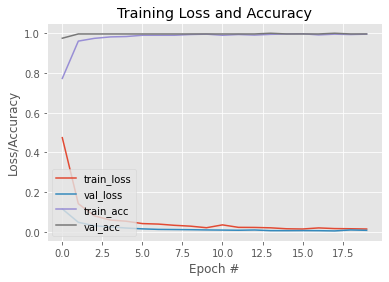

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])